### 前処理・DB接続

In [98]:
# データ分析に必要なライブラリ
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [99]:
# データベースを読み込む
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)
c = conn.cursor()

In [100]:
# データベースからデータを取得
sql = 'SELECT * FROM train_data'
train_info = pd.read_sql(sql, conn)

In [101]:
# データベースの中身を表示
print(train_info)

          id area              line       status               detail  \
0          1  北海道       函館本線[小樽～札幌]         平常運転        事故・遅延情報はありません   
1          2  北海道      函館本線[札幌～岩見沢]         平常運転        事故・遅延情報はありません   
2          3  北海道      函館本線[函館～長万部]         平常運転        事故・遅延情報はありません   
3          4  北海道      函館本線[長万部～小樽]         平常運転        事故・遅延情報はありません   
4          5  北海道      函館本線[岩見沢～旭川]         平常運転        事故・遅延情報はありません   
5          6  北海道               千歳線         平常運転        事故・遅延情報はありません   
6          7  北海道             学園都市線         平常運転        事故・遅延情報はありません   
7          8  北海道              宗谷本線         平常運転        事故・遅延情報はありません   
8          9  北海道              石北本線         平常運転        事故・遅延情報はありません   
9         10  北海道              釧網本線         平常運転        事故・遅延情報はありません   
10        11  北海道              留萌本線         平常運転        事故・遅延情報はありません   
11        12  北海道      根室本線[滝川～富良野]         平常運転        事故・遅延情報はありません   
12        13  北海道       根室本線[新得～釧路]         平常運転   

In [102]:
# データベースからデータを読み込む
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

### 路線ごとの異常発生回数

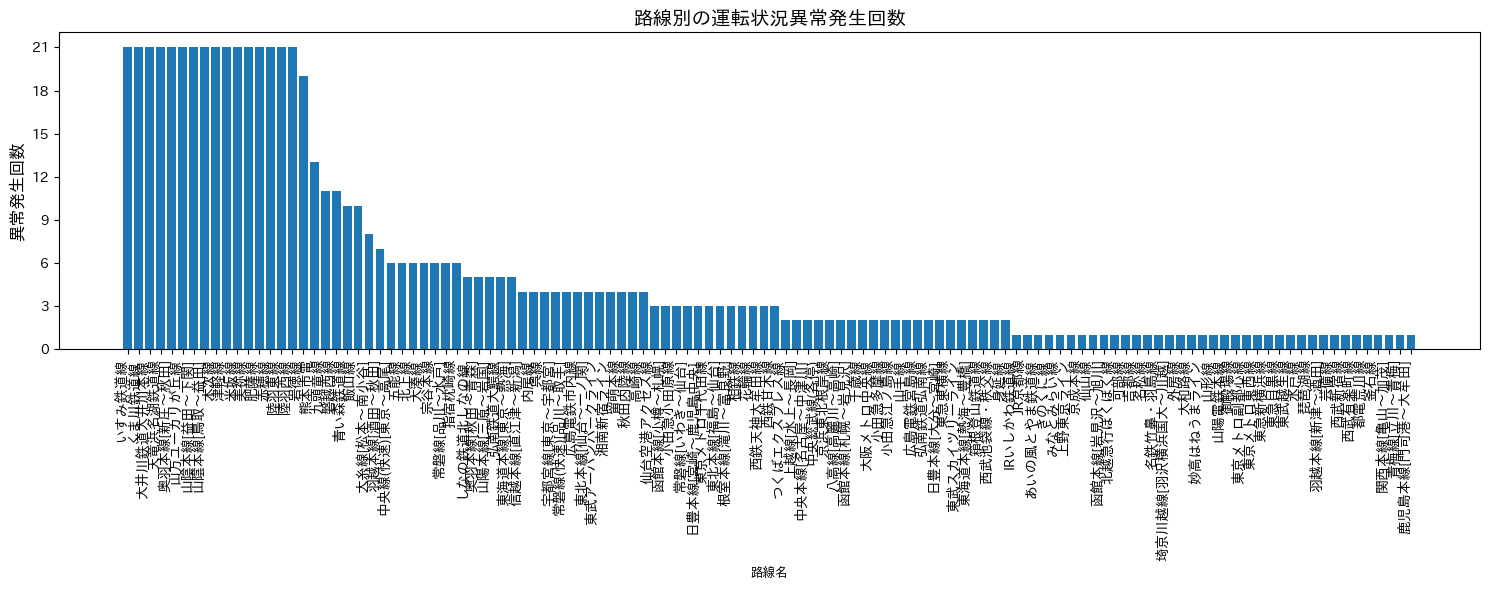

In [103]:
# 路線ごとの平常運転以外の件数をカウント
sql = """
SELECT line, COUNT(*) as count 
FROM train_data
WHERE status != '平常運転'
GROUP BY line 
ORDER BY count DESC
"""
abnormal_by_railway = pd.read_sql(sql, conn)

# グラフの作成
plt.figure(figsize=(15, 6))
plt.bar(abnormal_by_railway['line'], abnormal_by_railway['count'])
plt.title('路線別の運転状況異常発生回数', fontsize=14)
plt.xlabel('路線名', fontsize=9)
plt.ylabel('異常発生回数', fontsize=12)
plt.xticks(rotation=90, ha='right')

# y軸のメモリを3ごとに設定
ymax = abnormal_by_railway['count'].max()
plt.yticks(range(0, int(ymax) + 3, 3))  # 0からymaxまで3刻みでメモリを設定

plt.tight_layout()
plt.show()

conn.close()

### 時間帯別の異常発生回数

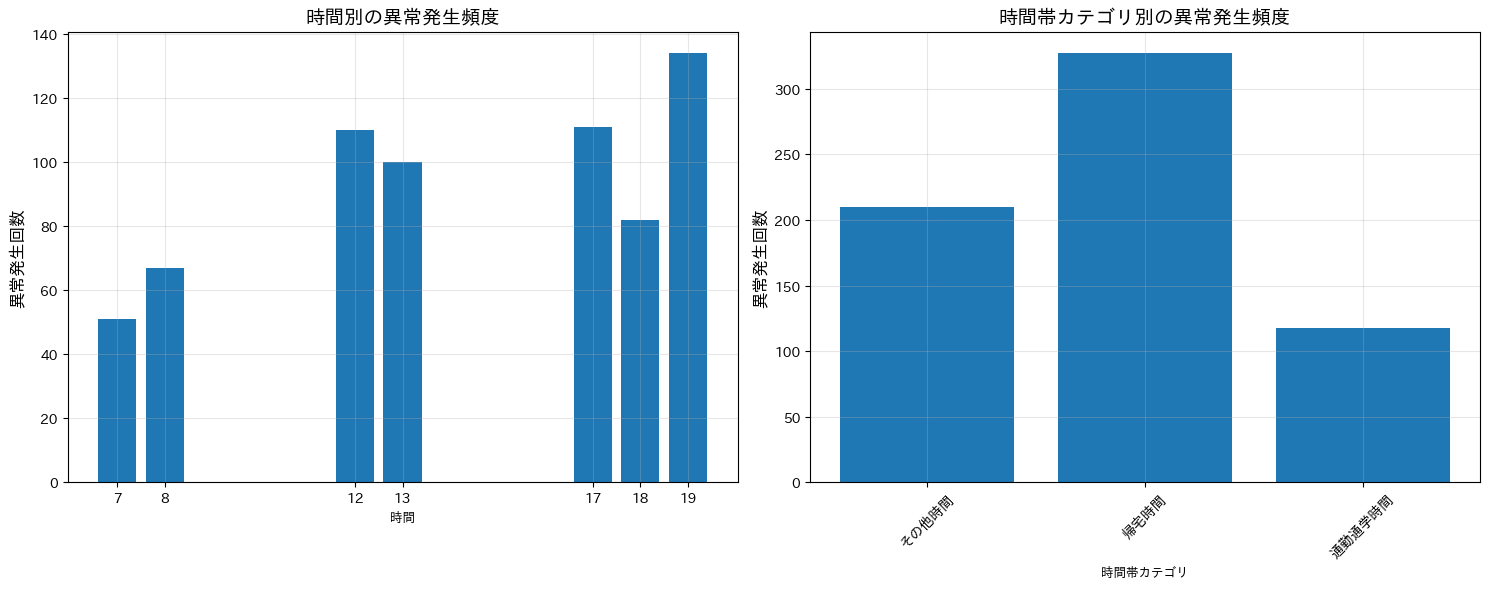


=== 時間帯ごとの詳細統計 ===

その他時間の統計:
12時: 110件
13時: 100件
小計: 210件

帰宅時間の統計:
17時: 111件
18時: 82件
19時: 134件
小計: 327件

通勤通学時間の統計:
7時: 51件
8時: 67件
小計: 118件


In [104]:
# 時間帯別の異常発生分析
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import japanize_matplotlib

# データベースを読み込む
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

def categorize_time(hour):
    if hour in [7, 8]:
        return '通勤通学時間'
    elif hour in [17, 18, 19]:
        return '帰宅時間'
    elif hour in [12, 13]:
        return 'その他時間'
    else:
        return '観測外'

# 時間帯別データの取得（SQLite用に修正）
sql = """
SELECT 
    CAST(strftime('%H', time) AS INTEGER) as hour,
    COUNT(*) as count
FROM train_data
WHERE status != '平常運転'
    AND CAST(strftime('%H', time) AS INTEGER) IN (7,8,12,13,17,18,19)
GROUP BY CAST(strftime('%H', time) AS INTEGER)
ORDER BY hour
"""
time_analysis = pd.read_sql(sql, conn)

# 時間帯カテゴリを追加と集計
time_analysis['time_category'] = time_analysis['hour'].apply(categorize_time)
category_analysis = time_analysis.groupby('time_category')['count'].sum().reset_index()

# 時間帯別の可視化
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(time_analysis['hour'], time_analysis['count'])
plt.title('時間別の異常発生頻度', fontsize=14)
plt.xlabel('時間', fontsize=9)
plt.ylabel('異常発生回数', fontsize=12)
plt.xticks([7,8,12,13,17,18,19])
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(category_analysis['time_category'], category_analysis['count'])
plt.title('時間帯カテゴリ別の異常発生頻度', fontsize=14)
plt.xlabel('時間帯カテゴリ', fontsize=9)
plt.ylabel('異常発生回数', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 時間帯ごとの詳細な統計
print("\n=== 時間帯ごとの詳細統計 ===")
for category in category_analysis['time_category'].unique():
    print(f"\n{category}の統計:")
    hours = time_analysis[time_analysis['time_category'] == category]
    for _, row in hours.iterrows():
        print(f"{row['hour']}時: {row['count']}件")
    print(f"小計: {hours['count'].sum()}件")

conn.close()

### 都心と郊外の異常発生パターン

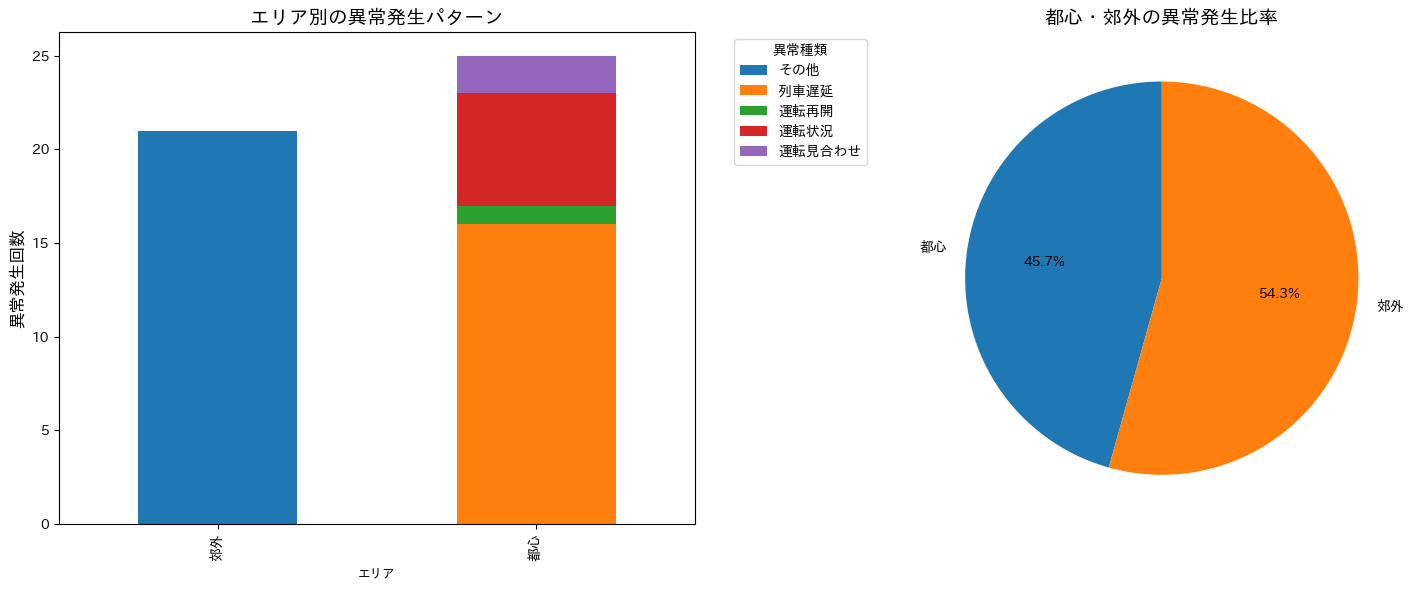


=== エリア別の異常発生統計 ===

都心の統計:
総異常発生件数: 25

異常種類別の内訳:
status
列車遅延      16
運転状況       6
運転見合わせ     2
運転再開       1
Name: count, dtype: int64

郊外の統計:
総異常発生件数: 21

異常種類別の内訳:
status
その他    21
Name: count, dtype: int64


In [105]:
# データ分析に必要なライブラリ
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import japanize_matplotlib

# データベースを読み込む
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

# 路線の分類定義
urban_rural_dict = {
    '都心': [
        '山手線', '中央線(快速)[東京～高尾]', '京浜東北根岸線', '東海道本線[東京～熱海]',
        '湘南新宿ライン', '横須賀線', '常磐線(快速)[品川～取手]', '総武線(快速)[東京～千葉]',
        '中央総武線(各停)'
    ],
    '郊外': [
        '北陸本線', '紀勢本線[和歌山～和歌山市]', '山陰本線[園部～鳥取]', '瀬戸大橋線[岡山～児島]', '木次線',
        '鳴門線', '山陽本線[下関～門司]', '鳴門線', '花咲線'
    ]
}

# エリア別データの取得
sql = """
SELECT 
    line,
    status,
    COUNT(*) as count
FROM train_data
WHERE status != '平常運転'
GROUP BY line, status
"""
area_analysis = pd.read_sql(sql, conn)

# エリア分類関数
def categorize_area(line):
    for area, lines in urban_rural_dict.items():
        if line in lines:
            return area
    return 'その他'

# エリア分類とピボットテーブル作成
area_analysis['area'] = area_analysis['line'].apply(categorize_area)
area_status_pivot = pd.pivot_table(
    area_analysis[area_analysis['area'].isin(['都心', '郊外'])],
    values='count',
    index='area',
    columns='status',
    aggfunc='sum',
    fill_value=0
)

# グラフ作成
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 積み上げ棒グラフ
area_status_pivot.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('エリア別の異常発生パターン', fontsize=14)
ax1.set_xlabel('エリア', fontsize=9)
ax1.set_ylabel('異常発生回数', fontsize=12)
ax1.legend(title='異常種類', bbox_to_anchor=(1.05, 1))

# パイチャート
area_total = area_analysis[area_analysis['area'].isin(['都心', '郊外'])].groupby('area')['count'].sum()
ax2.pie(area_total, 
        labels=['都心', '郊外'],
        autopct='%1.1f%%',
        startangle=90)
ax2.set_title('都心・郊外の異常発生比率', fontsize=14)

plt.tight_layout()
plt.show()

# エリア別統計情報の出力
print("\n=== エリア別の異常発生統計 ===")
for area in ['都心', '郊外']:
    area_data = area_analysis[area_analysis['area'] == area]
    print(f"\n{area}の統計:")
    print(f"総異常発生件数: {area_data['count'].sum()}")
    print("\n異常種類別の内訳:")
    print(area_data.groupby('status')['count'].sum().sort_values(ascending=False))

conn.close()

### 異常発生パターン

In [108]:
# 全行表示
pd.set_option('display.max_rows', None)

# statusがその他の列のみを抽出
other_status = train_info[train_info['status'] == 'その他']

# statusがその他のデータを表示
other_status

,id,area,line,status,detail,date,time
43,44,東北,奥羽本線[新庄～秋田],その他,大雨災害の影響で、新庄〜院内駅間...,2025-01-14,17:03:31
45,46,東北,米坂線,その他,大雨災害の影響で、今泉〜坂町駅間...,2025-01-14,17:03:31
47,48,東北,陸羽東線,その他,大雨災害の影響で、鳴子温泉〜新庄...,2025-01-14,17:03:31
48,49,東北,陸羽西線,その他,古口〜高屋駅間での道路工事の影響...,2025-01-14,17:03:31
54,55,東北,津軽線,その他,大雨災害の影響で、蟹田〜三厩駅間...,2025-01-14,17:03:31
204,205,関東,いすみ鉄道線,その他,国吉〜上総中川駅間での脱線事故の...,2025-01-14,17:03:31
224,225,関東,山万ユーカリが丘線,その他,車両都合の影響で、平日、朝夕ラッ...,2025-01-14,17:03:31
308,309,中部,天竜浜名湖鉄道線,その他,乗務員不足の影響で、3月14日ま...,2025-01-14,17:03:31
434,435,中国,赤穂線,その他,保守工事の影響で、17日までの各...,2025-01-14,17:03:31
435,436,中国,山陰本線[鳥取～益田],その他,保守工事の影響で、2月2日までの...,2025-01-14,17:03:31


In [109]:
# statusが列車遅延のデータを抽出
train_delay = train_info[train_info['status'] == '列車遅延']
train_delay

,id,area,line,status,detail,date,time
73,74,関東,湘南新宿ライン,列車遅延,東海道本線内で発生した人身事故の...,2025-01-14,17:03:31
75,76,関東,宇都宮線[東京～宇都宮],列車遅延,東海道本線内で発生した人身事故の...,2025-01-14,17:03:31
76,77,関東,高崎線,列車遅延,東海道本線内で発生した人身事故の...,2025-01-14,17:03:31
77,78,関東,常磐線(快速)[品川～取手],列車遅延,天王台駅での落し物拾得の影響で、...,2025-01-14,17:03:31
78,79,関東,常磐線[品川～水戸],列車遅延,天王台駅での落し物拾得の影響で、...,2025-01-14,17:03:31
611,612,関東,湘南新宿ライン,列車遅延,東海道本線内で発生した人身事故の...,2025-01-14,18:00:09
613,614,関東,中央線(快速)[東京～高尾],列車遅延,武蔵境駅での救護活動の影響で、一...,2025-01-14,18:00:09
614,615,関東,宇都宮線[東京～宇都宮],列車遅延,東海道本線内で発生した人身事故の...,2025-01-14,18:00:09
615,616,関東,高崎線,列車遅延,東海道本線内で発生した人身事故の...,2025-01-14,18:00:09
1149,1150,関東,湘南新宿ライン,列車遅延,東海道本線内で発生した人身事故の...,2025-01-14,19:00:11


In [110]:
# statusが運転状況のデータを抽出
train_stat = train_info[train_info['status'] == '運転状況']
train_stat

,id,area,line,status,detail,date,time
74,75,関東,東海道本線[東京～熱海],運転状況,二宮駅で発生した人身事故の影響で...,2025-01-14,17:03:31
230,231,中部,上越線[水上～長岡],運転状況,除雪作業の影響で、水上〜六日町駅...,2025-01-14,17:03:31
612,613,関東,東海道本線[東京～熱海],運転状況,二宮駅で発生した人身事故の影響で...,2025-01-14,18:00:09
767,768,中部,東海道本線[熱海～豊橋],運転状況,六合〜島田駅間での踏切内点検の影...,2025-01-14,18:00:09
1305,1306,中部,東海道本線[熱海～豊橋],運転状況,六合〜島田駅間での踏切内点検の影...,2025-01-14,19:00:11
2383,2384,中部,信越本線[直江津～新潟],運転状況,04:56頃、犀潟〜柏崎駅間での...,2025-01-15,08:05:23
2692,2693,北海道,千歳線,運転状況,函館本線内で発生した踏切支障の影...,2025-01-15,12:00:18
2715,2716,東北,東北本線[福島～仙台],運転状況,太子堂駅での安全確認の影響で、一...,2025-01-15,12:00:18
2718,2719,東北,仙台空港アクセス線,運転状況,太子堂駅での安全確認の影響で、一...,2025-01-15,12:00:18
2763,2764,関東,内房線,運転状況,強風の影響で、一部列車に遅れや運...,2025-01-15,12:00:18


In [111]:
train_aaa = train_info[train_info['status'] == '運転見合わせ']
train_aaa

,id,area,line,status,detail,date,time
1101,1102,東北,羽越本線[新津～酒田],運転見合わせ,小岩川〜あつみ温泉駅間で発生した...,2025-01-14,19:00:11
1846,1847,中部,九頭竜線,運転見合わせ,荒天予想の影響で、越前大野〜九頭...,2025-01-15,07:33:43
2101,2102,九州,熊本市電,運転見合わせ,熊本城・市役所前電停付近での線路...,2025-01-15,07:33:43
2152,2153,北海道,宗谷本線,運転見合わせ,強風の影響で、名寄〜稚内駅間の運...,2025-01-15,08:05:23
2177,2178,東北,東北本線[福島～仙台],運転見合わせ,太子堂駅での安全確認の影響で、岩...,2025-01-15,08:05:23
2178,2179,東北,常磐線[いわき～仙台],運転見合わせ,太子堂駅での安全確認の影響で、岩...,2025-01-15,08:05:23
2180,2181,東北,仙台空港アクセス線,運転見合わせ,太子堂駅での安全確認の影響で、運...,2025-01-15,08:05:23
2384,2385,中部,九頭竜線,運転見合わせ,荒天予想の影響で、越前大野〜九頭...,2025-01-15,08:05:23
2639,2640,九州,熊本市電,運転見合わせ,熊本城・市役所前電停付近での線路...,2025-01-15,08:05:23
2693,2694,北海道,宗谷本線,運転見合わせ,強風の影響で、名寄〜稚内駅間の運...,2025-01-15,12:00:18


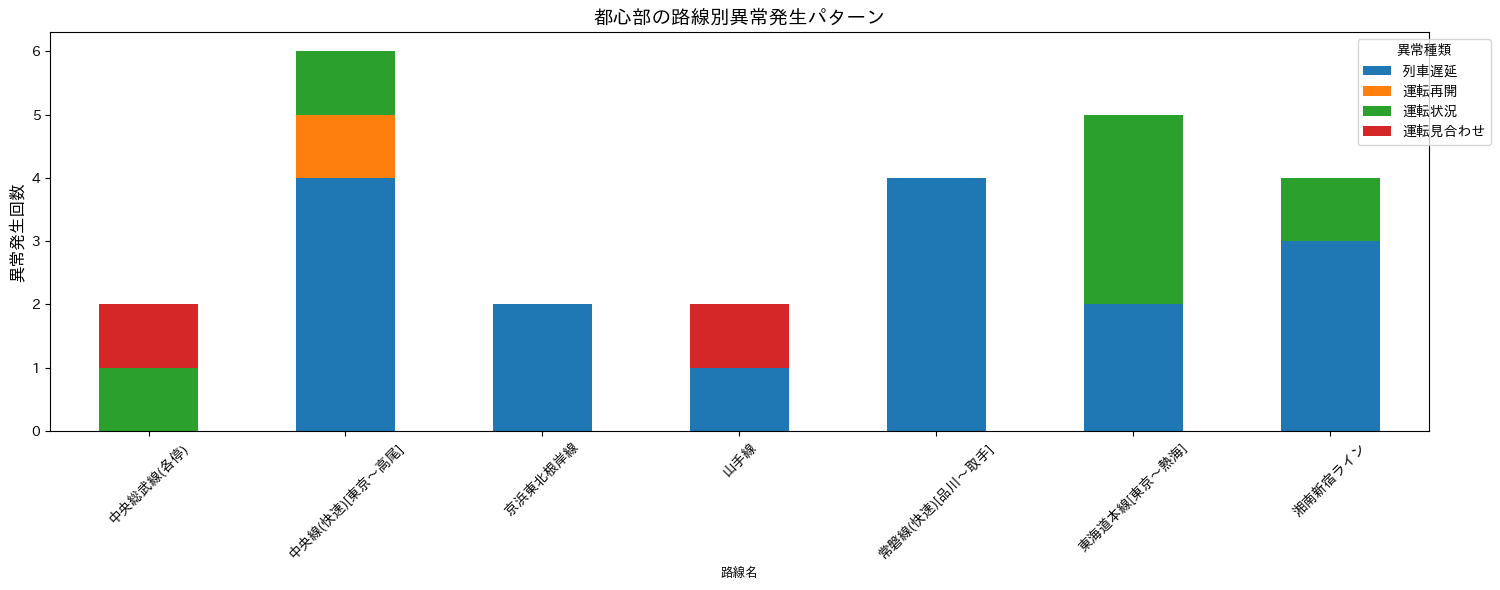

In [112]:
# 都心部での異常発生パターンを抽出して表示
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

sql_urban_analysis = """
SELECT
    line,
    status,
    COUNT(*) as count
FROM train_data
WHERE status != '平常運転'
    AND line IN (
        '山手線', '中央線(快速)[東京～高尾]', '京浜東北根岸線', '東海道本線[東京～熱海]',
        '湘南新宿ライン', '横須賀線', '常磐線(快速)[品川～取手]', '総武線(快速)[東京～千葉]',
        '中央総武線(各停)'
    )
GROUP BY line, status
"""
urban_analysis = pd.read_sql(sql_urban_analysis, conn)

urban_pivot = pd.pivot_table(
    urban_analysis,
    values='count',
    index='line',
    columns='status',
    aggfunc='sum',
    fill_value=0
)

urban_pivot.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('都心部の路線別異常発生パターン', fontsize=14)
plt.xlabel('路線名', fontsize=9)
plt.ylabel('異常発生回数', fontsize=12)
plt.legend(title='異常種類', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()